<a href="https://colab.research.google.com/github/TheGreatAndrew/ApplicationProgramming/blob/master/RL_2024_Online_Lecture_1_Intro_to_MushroomRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the TuDa reinforcement learning course - Online Practical Sessions

*   These online sessions will take place every Friday
*   They will provide extra information that will be helpful for the main course content and the assignments
* The assignments will be announced after the online practical sessions on 17th May, 14th June, and 5th July
* Run by the teaching assistants (TAs) - please ask questions on the Moodle/RL Discord if you want specific information that we might be able to help with

# Introduction to MushroomRL
## Why MushroomRL?
* Simple to implement and understand
* Standardised environment and algorithm interfaces
* Lots of preexisting code, algorithms, environments, & utilities
* Designed to be modular and easily extendable
* Use V 1.10.1
* Fun fact: this library was developed in part by Davide Tateo, our current lecturer!

Github: https://github.com/MushroomRL/mushroom-rl/tree/dev

Docs: https://mushroomrl.readthedocs.io/en/latest/

MushroomRL is stable for Python versions 3.8-3.11


# MushroomRL Object Interactions

Standard RL Diagram:

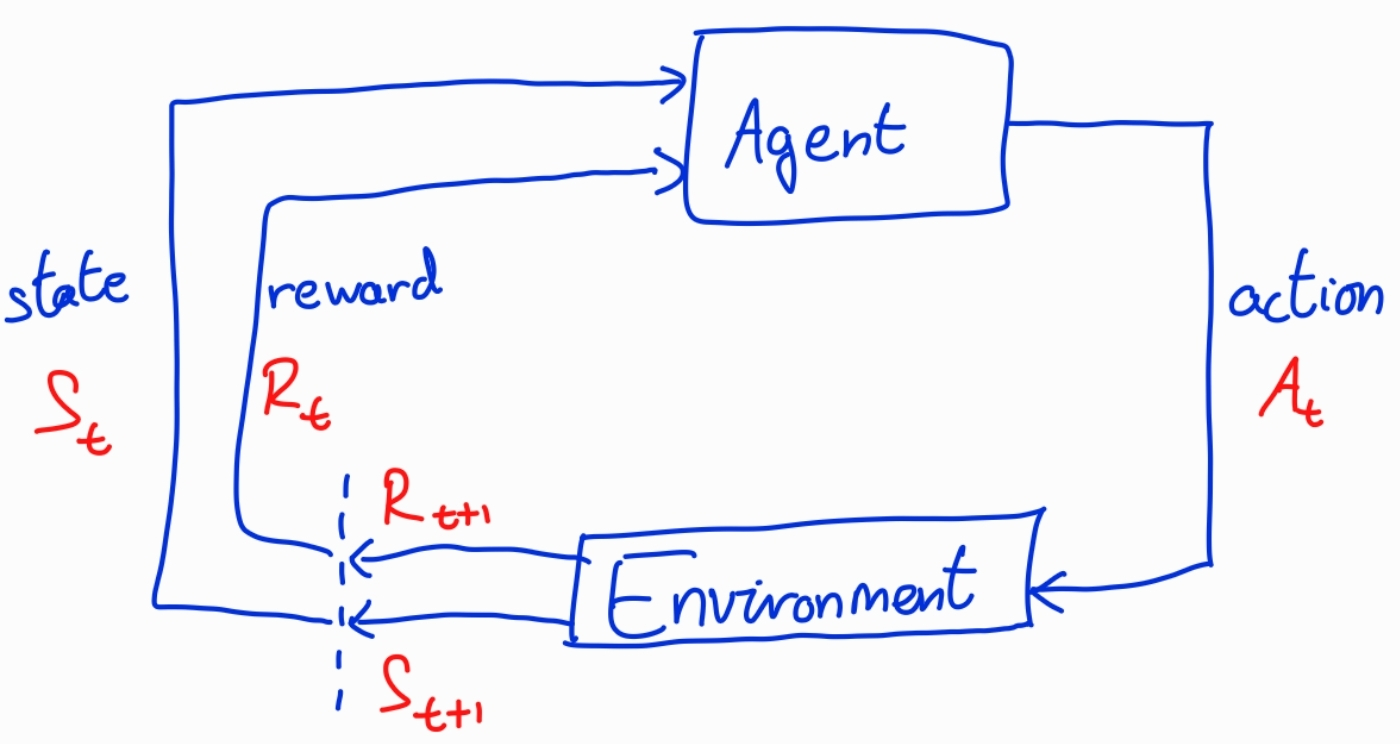

MushroomRL Interactions:

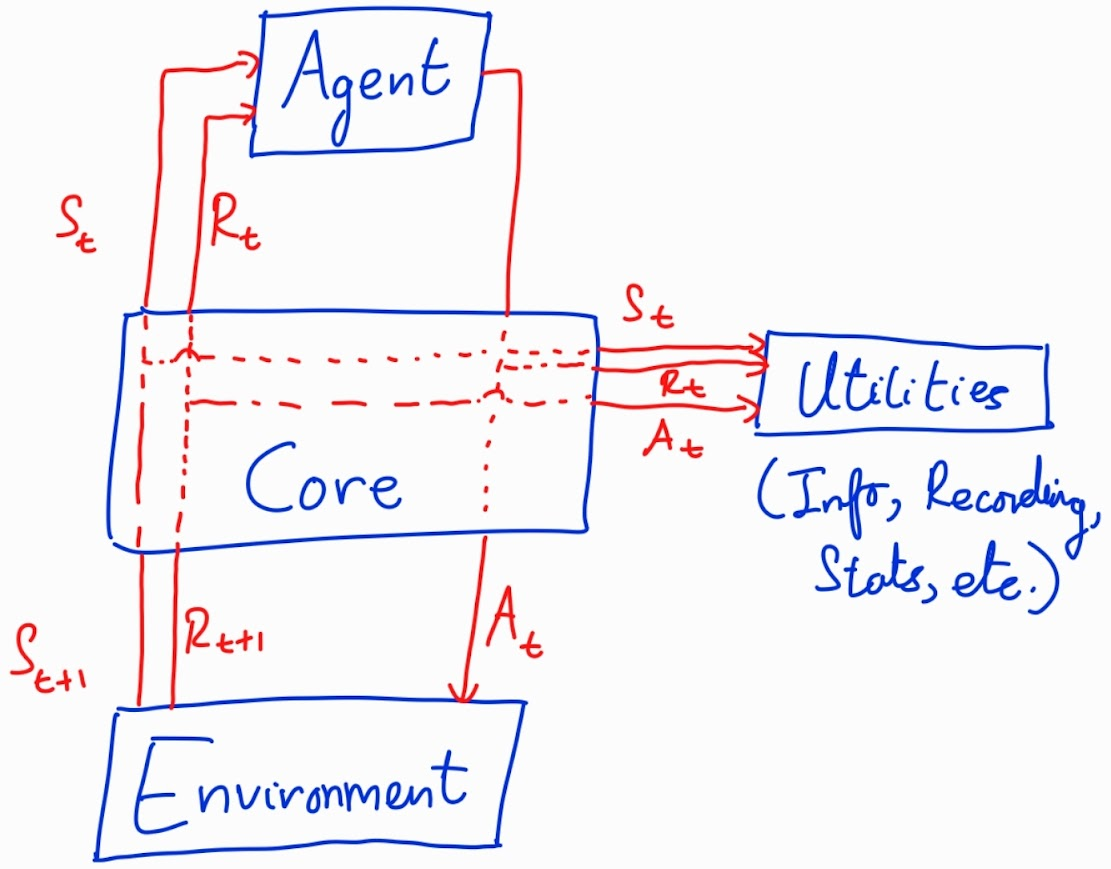


# MushroomRL Object Constructors & Interfaces
## Serializable

https://github.com/MushroomRL/mushroom-rl/blob/dev/mushroom_rl/core/serialization.py

The basis for many object classes in MushroomRL. Used for saving/loading objects.
* Don't need to understand how this works
* Just need to use the save/load methods


## Agent

https://github.com/MushroomRL/mushroom-rl/blob/dev/mushroom_rl/core/agent.py

constructor:
* MDP Info (to ensure actions are compatible with the policy)
* Policy (to choose the actions)
* Features (to extract relevant features from the state)

fit (updates policy, etc. when new data is available):
* dataset

draw_action:
* state
* → action

episode_start (resets policy)

Example hierarchy:
Serializable -> Agent -> TD -> QLearning

https://github.com/MushroomRL/mushroom-rl/blob/dev/mushroom_rl/algorithms/value/td/td.py

https://github.com/MushroomRL/mushroom-rl/blob/dev/mushroom_rl/algorithms/value/td/q_learning.py

## Environment

https://github.com/MushroomRL/mushroom-rl/blob/dev/mushroom_rl/core/environment.py

constructor:
* mdp_info

reset (resets the environment after an episode/training run is over)

step (takes an action and progresses the environment by one timestep)
* action
* → state

render (visualises the environment)

Example hierarchy:
Environment -> CarOnHill

https://github.com/MushroomRL/mushroom-rl/blob/dev/mushroom_rl/environments/car_on_hill.py

## MDPInfo
constructor:
* observation_space
* action_space
* gamma
* horizon
* dt (control timestep of the environment)

## Core

https://github.com/MushroomRL/mushroom-rl/blob/dev/mushroom_rl/core/core.py

constructor:
* agent
* mdp

learn:
* n_steps/n_episodes (how long it lasts)
* n_steps_per_fit/n_episodes_per_fit (how often to update)
* render

evaluate:
* n_steps/n_episodes (how long to evaluate for)
* render

reset (resets mdp, agent)



# Code example

In [ ]:
# Installation
!pip install mushroom_rl

In [ ]:
from mushroom_rl.environments import GridWorld

mdp = GridWorld(width=3, height=3, goal=(2, 2), start=(0, 0))

In [ ]:
from mushroom_rl.policy import EpsGreedy
from mushroom_rl.utils.parameters import Parameter

epsilon = Parameter(value=1.)
policy = EpsGreedy(epsilon=epsilon)

In [ ]:
from mushroom_rl.algorithms.value import QLearning

learning_rate = Parameter(value=.6)
agent = QLearning(mdp.info, policy, learning_rate)

In [ ]:
from mushroom_rl.core import Core

core = Core(agent, mdp)
core.learn(n_steps=100000, n_steps_per_fit=1)

In [ ]:
import numpy as np

shape = agent.Q.shape
q = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        state = np.array([i])
        action = np.array([j])
        q[i, j] = agent.Q.predict(state, action)
print(q)

[[ 6.561  7.29   6.561  7.29 ]
 [ 7.29   8.1    6.561  8.1  ]
 [ 8.1    9.     7.29   8.1  ]
 [ 6.561  8.1    7.29   8.1  ]
 [ 7.29   9.     7.29   9.   ]
 [ 8.1   10.     8.1    9.   ]
 [ 7.29   8.1    8.1    9.   ]
 [ 8.1    9.     8.1   10.   ]
 [ 0.     0.     0.     0.   ]]


# Harder Example

In [ ]:
# General imports
import numpy as np

# MushroomRL imports
from mushroom_rl.algorithms.value import TrueOnlineSARSALambda
from mushroom_rl.core import Core, Logger
from mushroom_rl.environments import Gym
from mushroom_rl.features import Features
from mushroom_rl.features.tiles import Tiles
from mushroom_rl.policy import EpsGreedy
from mushroom_rl.utils.dataset import compute_J
from mushroom_rl.utils.parameters import Parameter


np.random.seed()

# MDP
mdp = Gym(name='MountainCar-v0', horizon=np.inf, gamma=1.)

# Policy
epsilon = Parameter(value=0.2)
pi = EpsGreedy(epsilon=epsilon)

# Agent
n_tilings = 10
tilings = Tiles.generate(n_tilings, [10, 10],
                          mdp.info.observation_space.low,
                          mdp.info.observation_space.high)
features = Features(tilings=tilings)

learning_rate = Parameter(0.1 / n_tilings)

approximator_params = dict(input_shape=(features.size,),
                            output_shape=(mdp.info.action_space.n,),
                            n_actions=mdp.info.action_space.n)

algorithm_params = {'learning_rate': learning_rate,
                    'lambda_coeff': .9}

agent = TrueOnlineSARSALambda(mdp.info, pi,
                              approximator_params=approximator_params,
                              features=features, **algorithm_params)

# Core
core = Core(agent, mdp)

# Train
core.learn(n_episodes=40, n_steps_per_fit=1, render=False)
dataset = core.evaluate(n_episodes=1, render=True)

J = np.mean(compute_J(dataset, 1.))

logger = Logger(TrueOnlineSARSALambda.__name__, results_dir=None)
logger.strong_line()
logger.info('Experiment Algorithm: ' + TrueOnlineSARSALambda.__name__)

logger.info('J: %f' % J)


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
                                             

19/04/2024 09:08:02 [INFO] ###################################################################################################
19/04/2024 09:08:02 [INFO] Experiment Algorithm: TrueOnlineSARSALambda
19/04/2024 09:08:02 [INFO] J: -148.000000
